
# Om å finne illustrasjoner i bøker fra NB digital

Fra en oversikt over alle illustrasjoner i NB-digital (ca. 480 000 bøker) kan vi studere selve illustrasjonene. Hva som kan vises er avhengig av tilgangsnivå, og hvor vi er, på jobb på NB eller på privatmaskin. 

Det frie materialet kan nås fra hvor som helst, mens det som har restriksjoner også er begrenset innad i NB. For begrenset materiale er det kun mulig å få ut deler av en illustrasjon, men det er mulig å mekke det til så man får sett alt. Foreløpig er ikke det gjort. 

### Litt startkode

In [1]:
import dhlab.module_update as mu
mu.update("nbpictures", silent = True)
from nbpictures import show_illustrations_urn, urns_from_super, load_picture, get_urls_from_illustration_data, get_illustration_data_from_book
import nbpictures as nbp
from IPython.display import HTML, Markdown, display
from skimage import data, io, filters, feature, color
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mu.css()

Hent ut noen URN-er, eller bruk URN-er funnet annet sted

In [3]:
import imp


In [4]:
imp.reload(nbp)

<module 'nbpictures' from 'C:\\Users\\larsj\\Documents\\GitHub\\illustrations_bokhylla\\nbpictures.py'>

In [5]:
urns = nbp.urns_from_super("stup christiania", period=('19200101', '19900101'), conditions = {'digitalAccessibleOnly':'true','profile':'wwwnbno'})

Konverter bøker til illustrasjonsdata

In [24]:
mf = nbp.iiif_manifest(urns [0])

In [26]:
mf['metadata']

[{'label': 'Tilgang', 'value': 'Tilgang for norske IP-adresser'},
 {'label': 'Tittel', 'value': 'Christiania skiklub, 1877-1977'},
 {'label': 'Publisert', 'value': 'Moestue, 1977'},
 {'label': 'Emne',
  'value': 'oslo | jubileum | klubber | skiidrett | Christiania skiklub'},
 {'label': 'Andre opplysninger',
  'value': 'Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2015-06-03\n'},
 {'label': 'Språk', 'value': 'Norsk (Bokmål)'},
 {'label': 'Kilde for metadata',
  'value': 'nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=998520227944702202">998520227944702202</a>)'},
 {'label': 'Omfang', 'value': '175 s. ill.'},
 {'label': 'Medietype', 'value': 'bøker'},
 {'label': 'Dewey', 'value': '796.93'},
 {'label': 'UDC',
  'value': '796.92(09), 796(09):061.2, 796.92.06, (09), (481.13)'},
 {'label': 'Varig lenke',
  'value': '<a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2015051308316" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_20

In [31]:
mf['thumbnail']['@id']

'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_C1/full/0,200/0/native.jpg'

In [7]:
illustrations = get_illustration_data_from_book(urns[0])

In [68]:
books = {u:[get_urls_from_illustration_data(ill) for ill in get_illustration_data_from_book(u)[:20]] for u in urns[:5]}

In [69]:
books

{'URN:NBN:no-nb_digibok_2015051308316': ['https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,671,1023,984/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,1944,1023,1023/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0005/834,1262,366,448/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0006/0,330,1023,1023/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0022/349,368,1023,1023/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0030/342,265,881,1023/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0033/195,281,1023,1023/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0035/1090,451,693,76

In [8]:
pics = [get_urls_from_illustration_data(ill) for ill in illustrations]

In [9]:
pics

['https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,671,1023,984/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,1944,1023,1023/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0005/834,1262,366,448/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0006/0,330,1023,1023/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0022/349,368,1023,1023/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0030/342,265,881,1023/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0033/195,281,1023,1023/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0035/1090,451,693,764/full/0/native.jpg',
 'https://www.nb.no/servi

In [16]:
pic0 = io.imread(pics[5])

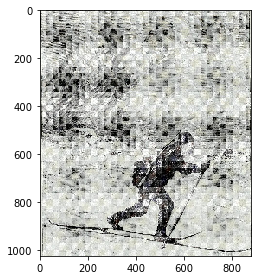

In [17]:
io.imshow(pic0)

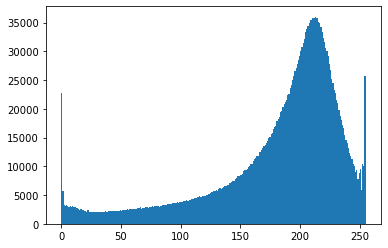

In [18]:
h = plt.hist(pic0.ravel(), bins = 256)
plt.show()

In [19]:
h[1]

array([  0.        ,   0.99609375,   1.9921875 ,   2.98828125,
         3.984375  ,   4.98046875,   5.9765625 ,   6.97265625,
         7.96875   ,   8.96484375,   9.9609375 ,  10.95703125,
        11.953125  ,  12.94921875,  13.9453125 ,  14.94140625,
        15.9375    ,  16.93359375,  17.9296875 ,  18.92578125,
        19.921875  ,  20.91796875,  21.9140625 ,  22.91015625,
        23.90625   ,  24.90234375,  25.8984375 ,  26.89453125,
        27.890625  ,  28.88671875,  29.8828125 ,  30.87890625,
        31.875     ,  32.87109375,  33.8671875 ,  34.86328125,
        35.859375  ,  36.85546875,  37.8515625 ,  38.84765625,
        39.84375   ,  40.83984375,  41.8359375 ,  42.83203125,
        43.828125  ,  44.82421875,  45.8203125 ,  46.81640625,
        47.8125    ,  48.80859375,  49.8046875 ,  50.80078125,
        51.796875  ,  52.79296875,  53.7890625 ,  54.78515625,
        55.78125   ,  56.77734375,  57.7734375 ,  58.76953125,
        59.765625  ,  60.76171875,  61.7578125 ,  62.75

In [20]:
hog0 = feature.hog(pic0, feature_vector = False)

In [50]:
hog0

array([[[[[0.14524733, 0.10601307, 0.10789369, ..., 0.00195519,
           0.        , 0.01352072],
          [0.02737342, 0.01016536, 0.01004718, ..., 0.00825801,
           0.01403732, 0.00529415],
          [0.02252333, 0.0170412 , 0.038239  , ..., 0.15193175,
           0.04263771, 0.        ]],

         [[0.31686911, 0.04868319, 0.        , ..., 0.00843797,
           0.00077286, 0.13977044],
          [0.02511739, 0.01431555, 0.06757548, ..., 0.07284462,
           0.02388828, 0.03429753],
          [0.07417158, 0.02491067, 0.03324597, ..., 0.12776077,
           0.13001989, 0.07029267]],

         [[0.31686911, 0.00394082, 0.01072732, ..., 0.01809975,
           0.03512281, 0.31686911],
          [0.04317349, 0.07145266, 0.05673806, ..., 0.06767698,
           0.07025355, 0.06545041],
          [0.04364786, 0.05288222, 0.0228709 , ..., 0.05089445,
           0.02608005, 0.01577047]]],


        [[[0.03527299, 0.01309893, 0.01294666, ..., 0.01064115,
           0.01808829, 0.006

In [23]:
nbp.display_finds??

In [52]:
corner0 = feature.corner_fast(color.rgb2gray(pic0))

In [32]:
from nbpictures import iiif_manifest

In [40]:
s = "<td>{i}</td>".format(i = 2)
s

'<td>2</td><td>2</td><td>2</td><td>2</td>'

In [77]:
def display_books(books, max_width = 100):
    """A dictionary of urns - urls is displayed """
    
    html_wrapper = lambda x: """<style>
    div {{
        margin-top:1px; 
        margin-bottom:2px}};
        
    img {{
        float:right; 
        width:10%; 
        max-width:{mxw}px}}
    </style>
    <body>{body}</body>""".format(body = x, mxw = max_width)

    div_wrapper = lambda x: """<div>{div_content}</div>""".format(div_content = x)
    book_divs = ""
    for u in books:
        mf = iiif_manifest(u)
        thumbnail = "<img src = '{thumbnail}'></img>".format(thumbnail = mf['thumbnail']['@id'])
        metainfo =  '\n'.join(["<b>{label}</b>{val}".format(label = x['label'], val = x['value']) for x in mf['metadata']])        
        imgs = '\n'.join(["<img src='{img_http}'></img>".format(img_http = pic_url) for pic_url in books[u]])
        book_divs += div_wrapper(thumbnail + metainfo + imgs)
    return html_wrapper(book_divs)

In [78]:
HTML(display_books(books, max_width = 50))

In [33]:
show_illustrations_urn??

In [32]:
show_illustrations_urn(urns[0], 'fr')

**Tilgang**: Tilgang for norske IP-adresser
**Tittel**: Christiania skiklub, 1877-1977
**Publisert**: Moestue, 1977
**Emne**: oslo | jubileum | klubber | skiidrett | Christiania skiklub
**Andre opplysninger**: Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2015-06-03

**Språk**: Norsk (Bokmål)
**Kilde for metadata**: nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=998520227944702202">998520227944702202</a>)
**Omfang**: 175 s. ill.
**Medietype**: bøker
**Dewey**: 796.93
**UDC**: 796.92(09), 796(09):061.2, 796.92.06, (09), (481.13)
**Varig lenke**: <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2015051308316" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2015051308316</a>
****: <a href="https://www.nb.no/items/760e96b4caa3a54840c3d28790caeac4?manifest=https://api.nb.no/catalog/v1/iiif/760e96b4caa3a54840c3d28790caeac4/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a>

"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,671,1023,984/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,1944,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0005/834,1262,366,448/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0006/0,330,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0022/349,368,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0030/342,265,881,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0033/195,281,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0035/1090,451,693,764/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0040/342,2079,1023,815/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0046/380,505,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0048/366,1796,1023,959/full/0/native.jpg'"
